In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.special import gammainc, gamma

plt.style.use('jcap')

DISTANCE_CUT = 2
F_GCE = 1.794113925439598e-09


# Catalog documented here:
# https://fermi.gsfc.nasa.gov/ssc/data/access/lat/8yr_catalog/4FGL_Catalog_submit.pdf

In [2]:
plt.style.use('jcap')

def load_file(fname, table=None):
    names = []
    f = open(fname, 'r')
    for l in f.readlines():
        if l == '':
            return
        if l[0] == '#':
            continue
        assert(l[0] == '[')
        peak_l, peak_b, source_l, source_b, name = l[1:-2].split(', ')
        name = name[2:-1]
        while name[-1] == " ":
            name = name[:-1]
        
        already_included = name in names
        if table is not None:
            for name2 in table["Source_Name"]:
                if name2 == name:
                    already_included = True
                    break
        if not already_included:
            names.append(name)
        
    return pd.DataFrame(data=np.asarray([names]).transpose(),
                        columns=('Source_Name',))
        
fermi_data = load_file("data/Fermi_front_only_4FGL_peak_identification_within_20_deg_search_.3_deg.txt");
fermi_data_extra = load_file("data/Fermi_front_only_4FGL_peak_identification_within_20_deg_search_.55_deg.txt", fermi_data);

print(len(fermi_data), "were in Fermilab's list")
print(len(fermi_data_extra), "were added under extension.")

103 were in Fermilab's list
7 were added under extension.


In [3]:
def load_dist_file(filename):
    names = []
    glons = []
    glats = []
    galact_cent_dists = []
    sun_count = 0
    
    f = open(filename)
    for line in f.readlines():
        if line == '\n' or line == '':
            continue
        entries = line.split(' ')
        while '' in entries: entries.remove('')
        number, _, name, _, glon, glat, z, x, y = entries
        if float(z) == 0.0 and float(x) == 0.0 and float(y) == 8.5:
            sun_count += 1
            
        galact_cent_dist = np.sqrt(float(z)**2 + float(y)**2 + float(x)**2)

        names.append(name)
        glons.append(float(glon))
        glats.append(float(glat))
        galact_cent_dists.append(galact_cent_dist)
    f.close()
    
    print(sun_count, "were at (0, 0. 8.5)")
    
    names = np.asarray(names)
    galact_cent_dists = np.asarray(galact_cent_dists)
    return pd.DataFrame(data={"Source_Name": names, "GLON":glons, "GLAT":glats, "Dist": galact_cent_dists})

all_distances = load_dist_file("data/known-pulsars.txt")

77 were at (0, 0. 8.5)


In [4]:
hdul = fits.open('data/gll_psc_v22.fit')
fgl_8_year = hdul[1].data
hdul.close()

hdul = fits.open('data/gll_psc_v27.fit')
fgl_10_year = hdul[1].data
hdul.close()

hdul = fits.open('data/gll_psc_v16.fit')# 3FGL
fgl_3 = hdul[1].data
hdul.close()

CUT_EXTRA_GALACTIC = True

def cut(row, cut_flags):
    #ROI cut
    if 20 < row["GLON"] < 340:
        return True
    if row["GLAT"] > 20 or row["GLAT"] < -20:
        return True
    if -2 < row["GLAT"] < 2:
        return True

    if CUT_EXTRA_GALACTIC:
        # Source type cut
        if not row["CLASS1"] in ['', 'psr', 'PSR', 'unk']:
            return True
        try:
            if not row["CLASS2"] in ['', 'psr', 'PSR', 'unk']:
                return True
        except:
            pass

        # Distance cut
        dist = get_distance(row["ASSOC1"])
        if dist is None:
            dist = get_distance(row["ASSOC2"])
        if dist is not None:
            if  dist > DISTANCE_CUT:
                return True

    if cut_flags:
        if row["Flags"] != 0:
            return True
    return False

In [5]:
pulsar_count = 0
for row in fgl_8_year:
    #ROI cut
    if 20 < row["GLON"] < 340:
        continue
    if row["GLAT"] > 20 or row["GLAT"] < -20:
        continue
    if -2 < row["GLAT"] < 2:
        continue

    if row["CLASS1"] in ['psr', 'PSR']:
        pulsar_count += 1
        #print(row["CLASS2"])
    elif row["CLASS2"] in ['psr', 'PSR']:
        pulsar_count += 1
        print(row["CLASS1"])
print(f"4FGL 8-year has {pulsar_count} pulsars:")



4FGL 8-year has 22 pulsars:


In [23]:
def cut_fluxes(fgl_data, flags, fermilab=False):
    global fermilab_pulsar_count
    fermilab_pulsar_count = 0
    allowed_fluxes = []
    for row in fgl_data:
        if cut(row, flags):
            continue
            
        if row["Source_Name"] == '4FGL J1823.5-3020':
            print(row["CLASS1"])
            continue
            
        '''if row["CLASS1"] in ["psr", "PSR"] or row["CLASS2"] in ["psr", "PSR"]:
            dist = get_distance(row["ASSOC1"])
            if dist is None:
                dist = get_distance(row["ASSOC2"])
            print("Pulsar encountered, dist", dist)'''
            
        if fermilab:
            if row["Source_Name"] not in list(fermi_data["Source_Name"]) \
            and row["Source_Name"] not in list(fermi_data_extra["Source_Name"]):
                if row["CLASS1"] in ["psr", "PSR"]:
                    print("Wavelet analysis cut a pulsar, flux:", row["Energy_Flux100"])
                try:
                    if row["CLASS2"] in ['psr', 'PSR']:
                        print("Wavelet analysis cut a pulsar, flux:", row["Energy_Flux100"])
                except:
                    pass
                continue
            else:
                if row["CLASS1"] in ["psr", "PSR"]:
                    fermilab_pulsar_count += 1
                try:
                    if row["CLASS2"] in ['psr', 'PSR']:
                        fermilab_pulsar_count += 1
                except:
                    pass
                
        allowed_fluxes.append(row["Energy_Flux100"])
    return allowed_fluxes

def get_distance(assocName):
    dists = all_distances["Dist"][all_distances["Source_Name"] == assocName[4:]]
    if len(dists) == 1:
        return float(dists)
    return None

In [47]:
fermilab_pulsar_count = 0
passed_fluxes_8_year = cut_fluxes(fgl_8_year, False)
passed_fluxes_8_year_cut = cut_fluxes(fgl_8_year, True)
passed_fluxes_10_year = cut_fluxes(fgl_10_year, False)
passed_fluxes_10_year_cut = cut_fluxes(fgl_10_year, True)
passed_fluxes_3 = cut_fluxes(fgl_3, False)
passed_fluxes_fermi_8_year = cut_fluxes(fgl_8_year, False, fermilab=True)
passed_fluxes_fermi_10_year = cut_fluxes(fgl_10_year, False, fermilab=True)
print("8 year total vs. fermi", len(passed_fluxes_8_year), len(passed_fluxes_fermi_8_year),
      sum(passed_fluxes_fermi_8_year) / F_GCE)
print("10 year total vs. fermi", len(passed_fluxes_10_year), len(passed_fluxes_fermi_10_year),
      sum(passed_fluxes_fermi_10_year) / F_GCE)

#print("Passed 10 year number: ", len(passed_fluxes_10_year))
#print("Passed 10 year flux: ", sum(passed_fluxes_10_year))
#print("Passed 10 year Rr: ", sum(passed_fluxes_10_year) / F_GCE)

PSR
PSR
PSR
PSR
Wavelet analysis cut a pulsar, flux: 5.06288e-12
PSR
Wavelet analysis cut a pulsar, flux: 4.487598e-12
Wavelet analysis cut a pulsar, flux: 2.7991745e-12
PSR
Wavelet analysis cut a pulsar, flux: 2.5999758e-12
8 year total vs. fermi 211 47 0.16899196849191833
10 year total vs. fermi 264 48 0.16678619221649327


[1.95904603e-12 2.65324763e-12 3.59344440e-12 4.86680645e-12
 6.59139321e-12 8.92709929e-12 1.20904791e-11]


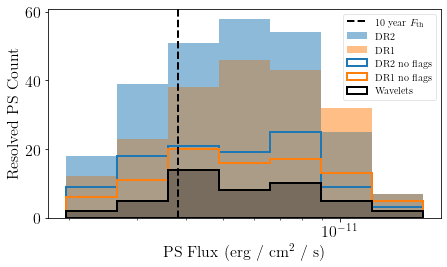

In [99]:
F_MIN = np.min(passed_fluxes_fermi_8_year)
F_MAX = np.max(passed_fluxes_fermi_8_year)
bins = 10**np.arange(np.log10(F_MIN), np.log10(F_MAX), 0.13173314511199238)

plt.axvline(label="10 year $F_\\mathrm{th}$", x=3.81e-12, color='k', linestyle='dashed')
dr2_num, _, _ = plt.hist(passed_fluxes_10_year, label="DR2", alpha=0.5, bins=bins)
dr1_num, _, _ = plt.hist(passed_fluxes_8_year, label="DR1", alpha=0.5, bins=bins)

intersection = np.minimum(dr2_num, dr1_num)
print(bins[:-1])
plt.bar(bins[:-1], intersection, width = [bins[i+1] - bins[i] for i in range(len(bins)-1)],
        align='edge', color=[(1 - (1 - 143/255)/1.333, 1 - (1 - 123/255)/1.333, 1 - (1 - 97/255)/1.333)])

plt.hist(passed_fluxes_10_year_cut, label="DR2 no flags", bins=bins, fill=False, histtype="stepfilled",
         linewidth=2, edgecolor='C0')
plt.hist(passed_fluxes_8_year_cut, label="DR1 no flags", bins=bins, fill=False, histtype="stepfilled",
         linewidth=2, edgecolor='C1')
#plt.hist(passed_fluxes_3, label="3 FGL", alpha=0.5, bins=bins)
plt.hist(passed_fluxes_fermi_8_year, alpha=0.3, bins=bins, color='k', histtype="stepfilled",
        linewidth=2)
plt.hist(passed_fluxes_fermi_8_year, bins=bins, fill=False,histtype="stepfilled",
        linewidth=2, label="Wavelets")

plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Resolved PS Count")
plt.xlabel("PS Flux (erg / cm$^2$ / s)")
#plt.axvline(label="1 photon", x=1.91e-13, color='k', linestyle='dotted')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("compare-catalogs.pdf")

In [103]:
print(len(passed_fluxes_10_year) / len(passed_fluxes_10_year))
print(len(passed_fluxes_8_year) / len(passed_fluxes_10_year))
print(len(passed_fluxes_10_year_cut) / len(passed_fluxes_10_year))
print(len(passed_fluxes_8_year_cut) / len(passed_fluxes_10_year))
print(len(passed_fluxes_fermi_8_year) / len(passed_fluxes_10_year))
print()
print(0.4 * len(passed_fluxes_10_year))
print(0.2 * len(passed_fluxes_10_year))
print(0.1 * len(passed_fluxes_10_year))
print(0.05 * len(passed_fluxes_10_year))
print()
print(0.4 * sum(passed_fluxes_10_year) / F_GCE)
print(0.2 * sum(passed_fluxes_10_year) / F_GCE)
print(0.1 * sum(passed_fluxes_10_year) / F_GCE)
print(0.05 * sum(passed_fluxes_10_year) / F_GCE)


1.0
0.7992424242424242
0.4090909090909091
0.3446969696969697
0.17803030303030304

105.60000000000001
52.800000000000004
26.400000000000002
13.200000000000001

0.36405343573857796
0.18202671786928898
0.09101335893464449
0.045506679467322245


# Recreate 3FGL mask

I want to recreate Zhong et al's 3FGL mask to see how many 4FGL points it beats out.

In [ ]:
fgl3_poses = []
fgl3_mask_radius_squared = []
for row in fgl_3:
    if 20 < row["GLON"] < 340:
        continue
    if row["GLAT"] > 20 or row["GLAT"] < -20:
        continue
    if -2 < row["GLAT"] < 2:
        continue
    TS = row["Sqrt_TS100_300"]**2 + row["Sqrt_TS300_1000"]**2 + \
        row["Sqrt_TS1000_3000"]**2 + row["Sqrt_TS3000_10000"]**2 + row["Sqrt_TS10000_100000"]**2
    if 9 < TS < 49:
        fgl3_mask_radius_squared.append(0.3**2)
    elif TS >= 49:
        fgl3_mask_radius_squared.append(1.0**2)
    else:
        continue
    lon = row["GLON"]
    if lon > 180:
        lon -= 360
    fgl3_poses.append((lon, row["GLAT"]))
    
def is_cut(coord):
    for i, (lon, lat) in enumerate(fgl3_poses):
        if (lon - coord[0])**2 + (lat - coord[1])**2 < fgl3_mask_radius_squared[i]:
            return True
    return False

In [ ]:
num_wavelets_outside_mask = 0
for row in fgl_8_year:
    if cut(row):
        continue
    lon = row["GLON"]
    if lon > 180:
        lon -= 360
    if row["Source_Name"] not in list(fermi_data["Source_Name"]) \
    and row["Source_Name"] not in list(fermi_data_extra["Source_Name"]):
        continue
    print(row["ASSOC_FGL"], lon, row["GLAT"], row["Source_Name"])
    if is_cut((lon, row["GLAT"])):
        continue
    num_wavelets_outside_mask += 1
print(num_wavelets_outside_mask, len(passed_fluxes_fermi_8_year))

In [ ]:
plt.figure(figsize=(6,6))
MAP_SIZE = 200
mask_map = np.zeros((MAP_SIZE, MAP_SIZE))
degrees = np.linspace(-20, 20, MAP_SIZE)
for x in range(MAP_SIZE):
    #if x % 10 == 0:
    #    print(x)
    for y in range(MAP_SIZE):
        lonlat = degrees[x], degrees[y]
        if abs(lonlat[1]) < 2:
            mask_map[y, x] = np.nan           
        elif is_cut(lonlat):
            mask_map[y, x] = 1
        else:
            mask_map[y, x] = 0
plt.pcolormesh(degrees, degrees, mask_map, )
plt.gca().set_aspect("equal")
print("Fraction of ROI unmasked:", 1 - np.nansum(mask_map) / np.count_nonzero(~np.isnan(mask_map)))

How many 4FGL sources are eliminated?

In [ ]:
cut_dr1_fluxes = []
cut_dr2_fluxes = []
for row in fgl_8_year:
    if cut(row):
        continue

    lon = row["GLON"]
    if lon > 180:
        lon -= 360
    if not is_cut((lon, row["GLAT"])):
        cut_dr1_fluxes.append(row["Energy_Flux100"])
        
for row in fgl_10_year:
    if cut(row):
        continue

    lon = row["GLON"]
    if lon > 180:
        lon -= 360
    if not is_cut((lon, row["GLAT"])):
        cut_dr2_fluxes.append(row["Energy_Flux100"])
        
print(len(passed_fluxes_8_year), len(cut_dr1_fluxes))
print(len(passed_fluxes_10_year), len(cut_dr2_fluxes))

In [ ]:
F_MIN = 1e-12
F_MAX = 5e-10#2e-11
bins = 10**np.linspace(np.log10(F_MIN), np.log10(F_MAX), 11)

plt.axvline(label="10 year $F_\\mathrm{th}$", x=4e-12, color='k', linestyle='dashed')
#plt.hist(passed_fluxes_10_year, label="10 year (4FGL-DR2)", alpha=0.5, bins=bins)
plt.hist(passed_fluxes_8_year, label="8 year (4FGL-DR1)", alpha=0.5, bins=bins, color="C1")
plt.hist(cut_dr1_fluxes, label="8 year masked (4FGL-DR1)", alpha=0.5, bins=bins, fill=False, histtype="stepfilled")
#plt.hist(passed_fluxes_3, label="4-year (3 FGL)", alpha=0.5, bins=bins)
plt.hist(passed_fluxes_fermi_8_year, label="Wavelet", alpha=0.3, bins=bins, color='k', linewidth=2)
plt.hist(passed_fluxes_fermi_8_year, bins=bins, fill=False,histtype="stepfilled",
        linewidth=2)
#plt.hist(passed_fluxes_fermi_8_year + passed_fluxes_3, bins=bins, fill=False, histtype="stepfilled",
#        linewidth=1)

plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Resolved PS Count")
plt.xlabel("PS Flux (erg / cm$^2$ / s)")
#plt.axvline(label="1 photon", x=1.91e-13, color='k', linestyle='dotted')
plt.legend(loc='upper right')

print(len(passed_fluxes_fermi_8_year) + len(passed_fluxes_3), len(cut_dr1_fluxes))

# Is every 3FGL PS associated with a 4FGL?

In [ ]:
assoc_3_names = {}

for row4 in fgl_8_year:
    if cut(row4):
        continue
    if row4["ASSOC_FGL"] != "" and row4["ASSOC_FGL"][:4]== "3FGL":
        #print(row4["ASSOC_FGL"][5:])
        assoc_3_names[row4["ASSOC_FGL"]] = (row4["Energy_Flux100"], row4["ASSOC1"])
        
fgl3_not_in_fgl4 = 0
in_both = 0
flux_shift = []
for row3 in fgl_3:
    if cut(row3):
        continue
    if row3["Source_Name"] not in assoc_3_names:
        fgl3_not_in_fgl4 += 1
        continue
    in_both += 1
    print(assoc_3_names[row3["Source_Name"]][1], row3["ASSOC1"])
    flux_shift.append((row3["Energy_Flux100"] - assoc_3_names[row3["Source_Name"]][0]) / assoc_3_names[row3["Source_Name"]][0])

In [ ]:
plt.hist(flux_shift, bins=10)
plt.xlabel("(3FGL flux - 4FGL flux) / 4FGL flux")
plt.ylabel("Number of sources common to both catalogs")

print(f"{in_both} sources are in both catalogs")
print(f"{fgl3_not_in_fgl4} sources are in 3FGL but not 4FGL")

# Does 4FGL 10 year explain the unidentified wavelet peaks?

In [ ]:
unidentified = [[  4.95,  19.25], [ -2.35,  19.15], [-0.15, -17.75],[16.55,  15.05], [ -4.55,  14.55],
    [  8.75,  -2.35], [ -8.55,  -5.85], [ 15.75, -11.45], [  3.25, -14.25], [ -6.55,  18.45]]

In [ ]:
DIST_THRESHOLD = 0.55
for row4 in fgl_8_year:
    ps_lon, ps_lat = row4["GLON"], row4["GLAT"]
    if ps_lon > 180:
        ps_lon -= 360
    for wave_lon, wave_lat in unidentified:
        if np.sqrt((ps_lon - wave_lon)**2 + (ps_lat - wave_lat)**2) < DIST_THRESHOLD:
            print("Matched wavelet to 4FGL PS")
            break

# All together

NameError: name 'cut_dr2_fluxes' is not defined

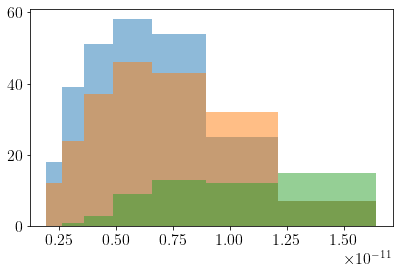

In [97]:
ALPHA=0.5
F_MIN = 1.9590460265411667e-12
F_MAX = 1.641357403841938e-11
RGB_SCALE = 0.8/256
bins = 10**np.linspace(np.log10(F_MIN), np.log10(F_MAX), 8)

plt.hist(passed_fluxes_10_year, label="4FGL-DR2", bins=bins, alpha=ALPHA, color="C0")
plt.hist(passed_fluxes_8_year, label="4FGL-DR1", bins=bins, alpha=ALPHA, color="C1")
plt.hist(passed_fluxes_3, label="3 FGL", bins=bins, color="C2", alpha=ALPHA)
plt.hist(cut_dr2_fluxes, label="DR2$-$mask", fill=False, bins=bins, histtype="stepfilled",
        edgecolor=[0x1f * RGB_SCALE,0x77 * RGB_SCALE,0xb4 * RGB_SCALE], linewidth=2, linestyle="solid")
plt.hist(cut_dr1_fluxes, label="DR1$-$mask", fill=False, bins=bins, histtype="stepfilled",
        edgecolor=[0xff * RGB_SCALE, 0x7f * RGB_SCALE, 0x0e * RGB_SCALE], linewidth=2, linestyle="dashed")

plt.hist(passed_fluxes_fermi_8_year, label="Wavelet", bins=bins, color=[0, 0, 0, 0.3], histtype="stepfilled",
        linewidth=2, edgecolor=[0, 0, 0, 1])

plt.axvline(label="DR2 $F_\\mathrm{th}$", x=4e-12, color='k', linestyle='dashed', linewidth=1)

print(len(passed_fluxes_fermi_8_year), len(cut_dr1_fluxes))

plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Resolved PS Count")
plt.xlabel("PS Flux (erg / cm$^2$ / s)")
#plt.axvline(label="1 photon", x=1.91e-13, color='k', linestyle='dotted')
plt.legend(loc='upper right')
plt.tight_layout()

#plt.savefig("compare-catalogs.pdf")

Done